+++
notebook = true
title = "Linear elasticity: disc with hole"
date = "2022-04-27"
author = "Linda Günther, Sophia Einspänner, Robert Habel, Christoph Lehmann and Thomas Nagel"
web_subsection = "small-deformations"
+++


<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./Linear_Disc_with_hole.ipynb" download="Linear_Disc_with_hole.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=Linear_Disc_with_hole.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Mechanics/Linear/DiscWithHole/Linear_Disc_with_hole.py"><img src="https://img.shields.io/static/v1?label=Source:&message=Linear_Disc_with_hole.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/Mechanics/Linear/DiscWithHole/Linear_Disc_with_hole.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

|<div style="width:330px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:330px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e8/TUBAF_Logo.svg" width="300"/></div>|
|---|---|--:|

In this benchmark example we consider a linear elastic small deformation problem. More specifically, a plate with a central hole that is put under tension on its top boundary is simulated. By exploiting symmetries, below we evaluate this problem just for the top right quarter of this disc.

Doing this it is important to define boundary conditions for the regarded section of the plate. For the bottom boundary ($x$-axis, $\theta=-90°$) and the left boundary ($y$-axis, $\theta=0°$) we prescribe Dirichlet boundary conditions that constrain the normal displacement along the edge to be zero. On the top, where a tensile traction is applied to the plate, Neumann boundary conditions are prescribed.

For the description of the plate and its load, some dimensions need to be defined. The quarter disc under consideration can be seen as a square with an edge length of $10\, \text{cm}$. The radius of the circular hole is $a = 2\, \text{cm}$ and the applied tension on the top boundary has a value of $\sigma = 10\, \text{kPa}$.

To fully capture and understand the behaviour of stress and strain distributions around the hole, it is necessary to also define material properties. In case of isotropic linear elasticity, the relevant parameters are the Young's modulus and Poisson's ratio. The following parameters are chosen here:

$ E = 1\,\text{MPa} \qquad \nu = 0.3$

For verification of the numerical implementation, the numerical solution of the problem will be compared to the analytical solution.

## Analytical solution

The overall stress distributions in the plate around the hole can be represented by Kirsch's Solution, which is expressed here in cylindrical coordinates. The following equations are valid for an infinitely extended plate. Since the hole is very small compared to the dimension of the plate, we can consider this condition as fulfilled. The parameter $\sigma$ is the applied tension and $a$ is the radius of the inner hole. $r$ and $\theta$ are the cylindrical coordinates of a point in the plate. $r$ is measured from the origin (i.e., center of the hole), and $\theta$ is measured clockwise from the positive $y$-axis, i.e. the $x$-axis is at $\theta = -90°$.

$$
\begin{align}
    \sigma_{rr} \left( r , \theta \right) &=
    \frac{\sigma}{2}
    \left[ \left( 1 - \frac{a^2}{r^2} \right) + \left( 1 + 3 \frac{a^4}{r^4} - 4 \frac{a^2}{r^2} \right) \cos \left( 2 \theta \right) \right]
\\
    \sigma_{\theta \theta} \left( r , \theta \right) &=
    \frac{\sigma}{2}
    \left[ \left( 1 + \frac{a^2}{r^2} \right) - \left( 1 + 3 \frac{a^4}{r^4} \right) \cos \left( 2 \theta \right) \right]
\\
    \sigma_{r \theta} \left( r , \theta \right) &=
    - \frac{\sigma}{2}
    \left[ \left( 1 - 3 \frac{a^4}{r^4} + 2 \frac{a^2}{r^2} \right) \sin \left( 2 \theta \right) \right]
\end{align}
$$

For visualization of the stress distribution within the plate the stresses $\sigma_{rr}$, $\sigma_{\theta\theta}$ and $\sigma_{r\theta}$ are plotted along the $x$- and $y$-axes as well as along the diagonal ($\theta = -45°$).
As can be seen below, the hole causes characteristic stress distributions.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pyvista as pv

In [2]:
# Some plot settings
plt.style.use("seaborn-v0_8-deep")
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.color"] = "black"
plt.rcParams["legend.frameon"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["font.size"] = 14
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["figure.figsize"] = (8, 6)

In [3]:
def kirsch_sig_rr(sig, r, theta, a):
    # Änderung in Heaviside-Funktion: Spannung erst ab r=1.99... auf Null setzen, da erster Eintrag von dist_sorted etwas kleiner als 2 ist
    return (
        0.5
        * sig
        * (
            (1 - a**2 / r**2)
            + (1 + 3 * np.power(a, 4) / np.power(r, 4) - 4 * a**2 / r**2)
            * np.cos(2 * np.pi * theta / 180)
        )
        * np.heaviside(r + 1e-7 - a, 1)
    )


def kirsch_sig_tt(sig, r, theta, a):
    return (
        0.5
        * sig
        * (
            (1 + a**2 / r**2)
            - (1 + 3 * np.power(a, 4) / np.power(r, 4))
            * np.cos(2 * np.pi * theta / 180)
        )
        * np.heaviside(r + 1e-7 - a, 1)
    )


def kirsch_sig_rt(sig, r, theta, a):
    return (
        -0.5
        * sig
        * (
            (1 - 3 * np.power(a, 4) / np.power(r, 4) + 2 * a**2 / r**2)
            * np.sin(2 * np.pi * theta / 180)
        )
        * np.heaviside(r + 1e-7 - a, 1)
    )

### Stress distribution along the $x$-axis ($\theta= -90°$, orthogonal to the load)

At larger distances from the hole the stresses are approximately distributed as if the plate had no hole ($\sigma_{rr} \equiv \sigma_{xx} \approx 0$, $\sigma_{r\theta} \equiv \sigma_{xy} = 0$, $\sigma_{\theta\theta} \equiv \sigma_{yy} = 10\,\text{kPa}$).
As the hole is approached, the tangential stress increases until it reaches its maximum value directly at the contour.
Interestingly, that value is three times as high as the applied traction. It can be concluded that the hole leads to a **threefold stress concentration**.

(0.0, 30.0)

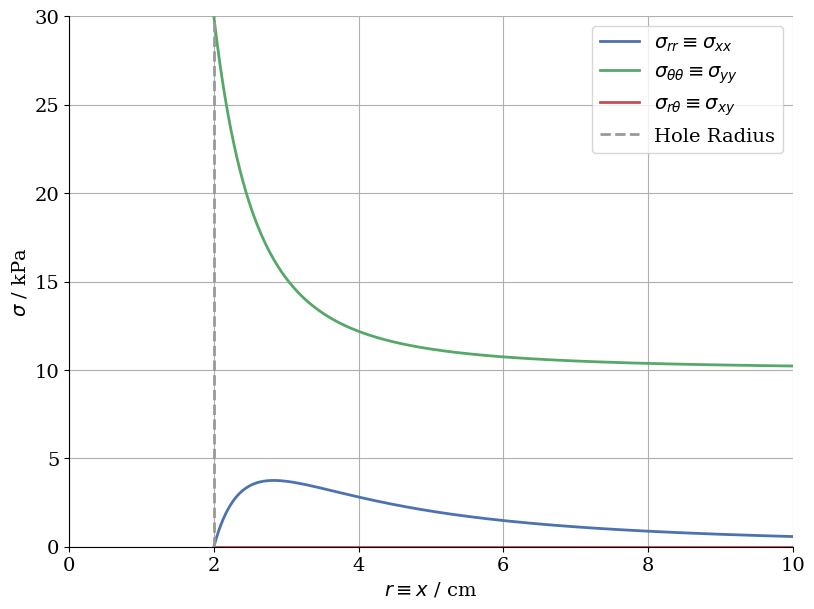

In [4]:
r = np.linspace(2, 10, 1000)
plt.plot(r, kirsch_sig_rr(10, r, -90, 2), label=r"$\sigma_{rr} \equiv \sigma_{xx}$")
plt.plot(
    r,
    kirsch_sig_tt(10, r, -90, 2),
    label=r"$\sigma_{\theta \theta} \equiv \sigma_{yy}$",
)
plt.plot(
    r, kirsch_sig_rt(10, r, -90, 2), label=r"$\sigma_{r \theta} \equiv \sigma_{xy}$"
)
plt.plot([2, 2], [0, 30], color="0.6", linestyle="--", label="Hole Radius")
plt.legend(loc="upper right")
plt.tight_layout()
plt.grid(True)
plt.xlabel(r"$r\equiv x$ / cm")
plt.xlim(0, 10)
plt.ylabel(r"$\sigma$ / kPa")
plt.ylim(0, 30)

### Stress distribution along the diagonal ($\theta= -45°$)

(0.0, 10.0)

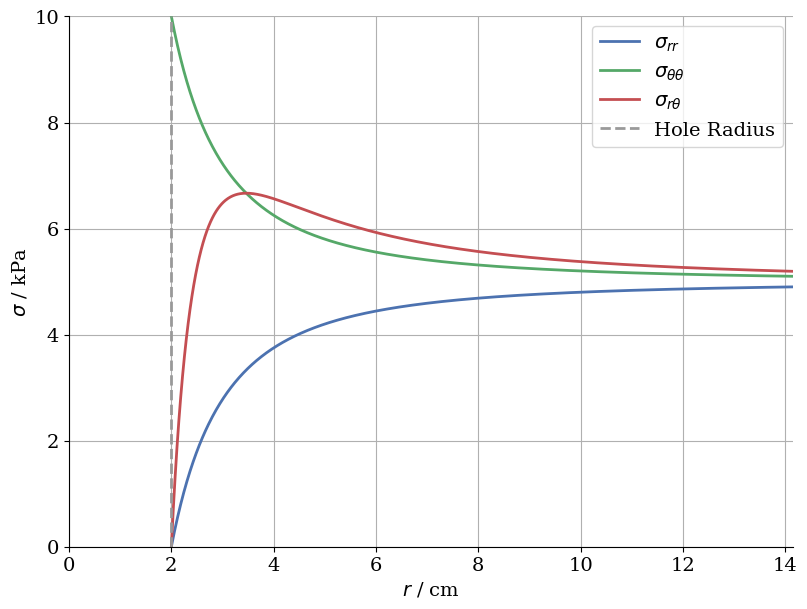

In [5]:
r = np.linspace(2, 14.14, 1000)
plt.plot(r, kirsch_sig_rr(10, r, -45, 2), label=r"$\sigma_{rr}$")
plt.plot(r, kirsch_sig_tt(10, r, -45, 2), label=r"$\sigma_{\theta \theta}$")
plt.plot(r, kirsch_sig_rt(10, r, -45, 2), label=r"$\sigma_{r \theta}$")
plt.axvline(2, color="0.6", linestyle="--", label="Hole Radius")
plt.legend(loc="upper right")
plt.tight_layout()
plt.grid(True)
plt.xlabel(r"$r$ / cm")
plt.xlim(0, 14.14)
plt.ylabel(r"$\sigma$ / kPa")
plt.ylim(0, 10)

### Stress distribution along the $y$-axis ($\theta=0°$, parallel to the applied tension)

**Attention**: Radius is plotted along the vertical axis. I.e., upwards direction in the plot corresponds to the upwards ($y$) direction of the problem.

The horizontal stress near the hole amounts to the negative of the applied tension. Far away from the hole ($r\to\infty$) it vanishes.

The vertical stress is zero at the edge of the hole and exhibits a sign change in the vicinity of the hole.

(-10.0, 10.0)

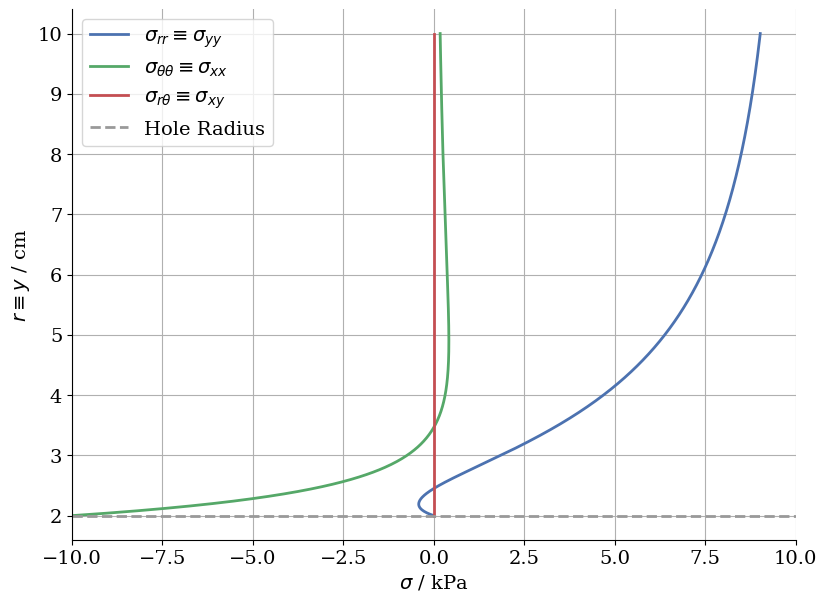

In [6]:
r = np.linspace(2, 10, 1000)
plt.plot(kirsch_sig_rr(10, r, 0, 2), r, label=r"$\sigma_{rr} \equiv \sigma_{yy}$")
plt.plot(
    kirsch_sig_tt(10, r, 0, 2), r, label=r"$\sigma_{\theta \theta} \equiv \sigma_{xx}$"
)
plt.plot(kirsch_sig_rt(10, r, 0, 2), r, label=r"$\sigma_{r \theta} \equiv \sigma_{xy}$")
plt.axhline(2, color="0.6", linestyle="--", label="Hole Radius")
plt.legend()
plt.tight_layout()
plt.grid(True)
ax = plt.gca()
plt.ylabel(r"$r\equiv y$ / cm")
plt.xlabel(r"$\sigma$ / kPa")
plt.xlim(-10, 10)

### 2D color plots

For gaining a deeper insight for the planar stress distribution in the plate around the hole the following 2D plots are helpful. The magnitude of the acting stresses is expressed by a chromatic graduated scale in separate plots for $\sigma_{rr}$, $\sigma_{\theta\theta}$ and $\sigma_{r\theta}$.

In [7]:
def cart_to_cyl(x, y):
    return [np.sqrt(x**2 + y**2), np.rad2deg(np.arctan(x / y))]

In [8]:
X, Y = np.meshgrid(np.linspace(0.1, 10, 1000), np.linspace(0.1, 10, 1000))

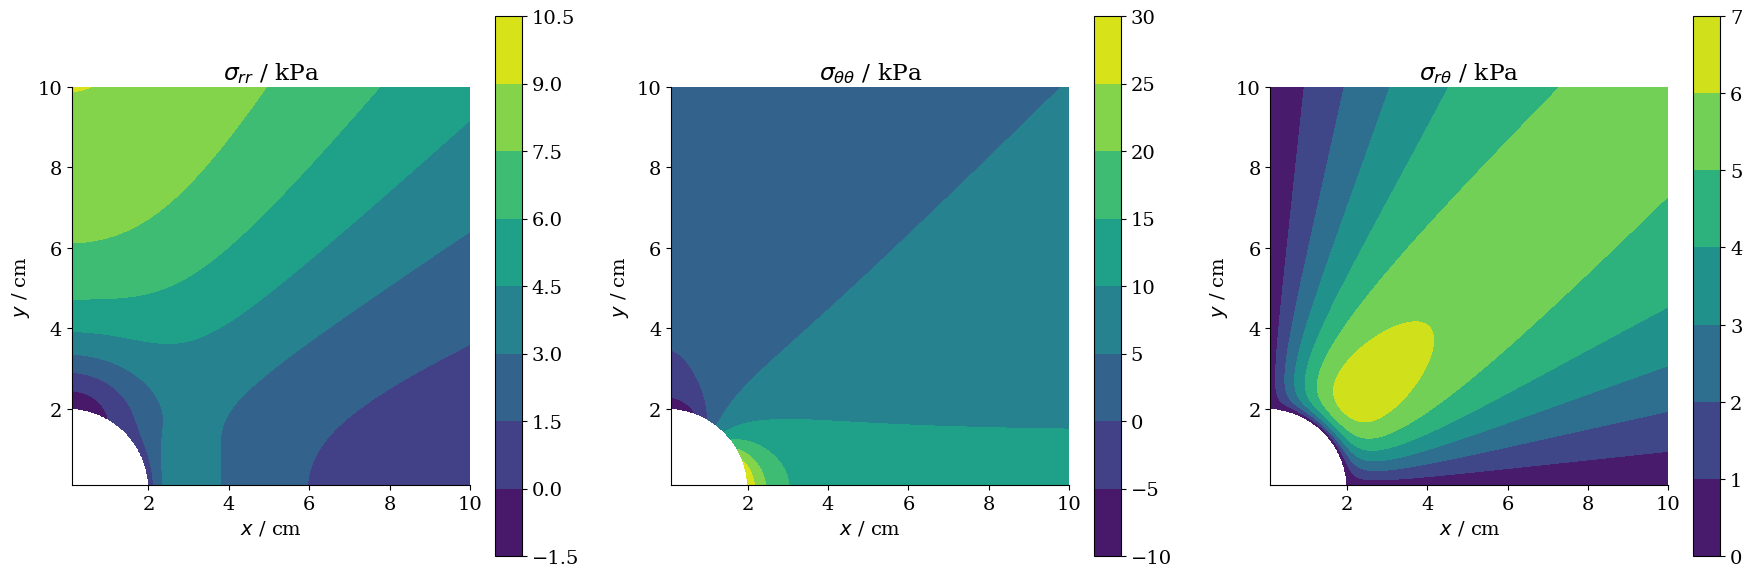

In [9]:
# cylindical coordinates from Cartesian grid
r, theta = cart_to_cyl(X, Y)
eps = 1e-2

fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
l1 = ax[0].contourf(
    X, Y, np.ma.masked_array(kirsch_sig_rr(10, r, -theta, 2), mask=r < 2)
)
l2 = ax[1].contourf(
    X, Y, np.ma.masked_array(kirsch_sig_tt(10, r, -theta, 2), mask=r < 2)
)
l3 = ax[2].contourf(
    X, Y, np.ma.masked_array(kirsch_sig_rt(10, r, -theta, 2), mask=r < 2)
)
fig.colorbar(l1, ax=ax[0])
fig.colorbar(l2, ax=ax[1])
fig.colorbar(l3, ax=ax[2])
for i in range(3):
    ax[i].set_aspect("equal")
    ax[i].set_xlabel("$x$ / cm")
    ax[i].set_ylabel("$y$ / cm")
ax[0].set_title(r"$\sigma_{rr}$ / kPa")
ax[1].set_title(r"$\sigma_{\theta\theta}$ / kPa")
ax[2].set_title(r"$\sigma_{r\theta}$ / kPa")
fig.tight_layout()

## Numerical solution

In the following section the previously analytically considered problem of the plate with a central hole is solved with numerical methods (FEM in OpenGeoSys).
OpenGeoSys performs computations in Cartesian coordinates.
In order to control, display and compare the results of the numerical solution with the analytical it is necessary to convert the output values from  Cartesian coordinates to polar coordinates.
The formulae below are used to obtain the coordinates $r$ and $\theta$ of the polar coordinate system.

$$
\begin{align}
    r &= \sqrt{\left(x^2+y^2\right)}
\\
    \theta &= \arctan\left(\frac yx \right)
\\
\end{align}
$$

For the simulation of the numerical model, some assumptions have to be made:

* The analytical solution is strictly correct only for an infinitely extended plate.
    This requirement can only be approximated in the numerical method. The dimensions of the considered plate must be much larger than the hole. With a hole diameter of $4\, \text{cm}$ and a size of $20\times20\, \text{cm}$ the plate can be considered as infinitely extended. Indeed, a general rule implied that the range of borders should be about five times the size of the cavity.
* For numerical simulations, it is necessary to specify the mesh resolution with which the model is calculated. A finer mesh provides more detailed gradients but takes more time for calculation, whereas a coarser mesh yields less accurate values, but in a shorter time.
* Another assumption that enables us to work with a two-dimensional plate model is the plain strain condition. That means that deformations only occur in one plane.

Simultaneous to the analytical solution the results of the numerical model are plotted along the $x$-, $y$- and diagonal axis. To visualize local differences to the analytically computed stress distribution of $\sigma_{rr}$, $\sigma_{\theta\theta}$ and $\sigma_{r\theta}$ the latter are also added in the plots as dotted lines.<br>
For a better presentation of these differences and as a basis for the following error analysis, plots for absolute and relative error along the regarded axes are have been made.

In [10]:
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [11]:
model = ot.Project(input_file="disc_with_hole.prj", output_file="disc_with_hole.prj")

In [12]:
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir}")

Project file written to output.
Simulation: disc_with_hole.prj
Status: finished successfully.
Execution took 0.2574894428253174 s


In [13]:
pv.set_plot_theme("document")
pv.set_jupyter_backend("static")  # comment out for interactive graphics

In [14]:
reader = pv.get_reader(f"{out_dir}/disc_with_hole.pvd")
reader.set_active_time_value(1.0)  # go to 1 s
mesh = reader.read()[0]  # nulltes Gitter lesen

In [15]:
def vec4_to_mat3x3cart(vec4):
    # theta = np.arctan2(ys, xs)

    m = np.zeros((3, 3))
    m[0, 0] = vec4[0]
    m[1, 1] = vec4[1]
    m[2, 2] = vec4[2]
    m[0, 1] = vec4[3]
    m[1, 0] = vec4[3]

    return np.matrix(m)


def vec4_to_mat3x3polar(
    vec4, xs, ys
):  # Fkt wandelt Kelvin Darstellung (von ogs ausgegeben) in Tensor um
    m_cart = vec4_to_mat3x3cart(vec4)

    theta = np.arctan2(ys, xs)

    rot = np.matrix(np.eye(3))  # 3x3 Einheitsmatrix
    rot[0, 0] = np.cos(theta)
    rot[0, 1] = -np.sin(theta)
    rot[1, 0] = np.sin(theta)
    rot[1, 1] = np.cos(theta)  # rot = Drehmatrix, Drehung um z-Achse

    return rot.T * m_cart * rot

### Stress distribution along the x-axis ($\theta = -90°$)

In [16]:
pt1 = (0, 1e-6, 0)
pt2 = (10, 1e-6, 0)
xaxis = pv.Line(pt1, pt2, resolution=2)
line_mesh = mesh.slice_along_line(xaxis)

xs = line_mesh.points[:, 0]  # x (0) coordinate of each point (Spalte 0)
ys = line_mesh.points[:, 1]  # y Koordinate jedes Punktes (Spalte 1)
dist_from_origin = np.hypot(xs, ys)  # Abstand vom Ursprung (= Radius)
indices_sorted = np.argsort(
    dist_from_origin
)  # Indizes der Punkte sortieren nach ihrem Abstand vom Ursprung
dist_sorted = dist_from_origin[indices_sorted]  # index magic

In [17]:
sig = line_mesh.point_data["sigma"]

In [18]:
num_points = sig.shape[0]  # entspricht len(sig) d.h Anzahl der Punkte, hier 36
sig_rr = np.zeros(num_points)  # Liste von 36 Nullen
sig_tt = np.zeros(num_points)
sig_rt = np.zeros(num_points)
f_abs_rr = np.zeros(num_points)
f_abs_tt = np.zeros(num_points)
f_abs_rt = np.zeros(num_points)
f_rel_rr = np.zeros(num_points)
f_rel_tt = np.zeros(num_points)
f_rel_rt = np.zeros(num_points)

In [19]:
for pt_idx in range(num_points):
    sig_vec = sig[pt_idx, :]
    xs = line_mesh.points[pt_idx, 0]
    ys = line_mesh.points[pt_idx, 1]
    sig_polar = vec4_to_mat3x3polar(sig_vec, xs, ys)
    sig_rr[pt_idx] = sig_polar[0, 0]
    sig_tt[pt_idx] = sig_polar[1, 1]
    sig_rt[pt_idx] = sig_polar[0, 1]

In [20]:
sig_rr_sorted = sig_rr[indices_sorted]
sig_tt_sorted = sig_tt[indices_sorted]
sig_rt_sorted = sig_rt[indices_sorted]

In [21]:
for pt_idx in range(num_points):
    f_abs_rr[pt_idx] = sig_rr_sorted[pt_idx] * 1000 - kirsch_sig_rr(
        10, dist_sorted[pt_idx], -90, 2
    )
    f_abs_tt[pt_idx] = sig_tt_sorted[pt_idx] * 1000 - kirsch_sig_tt(
        10, dist_sorted[pt_idx], -90, 2
    )
    f_abs_rt[pt_idx] = sig_rt_sorted[pt_idx] * 1000 - kirsch_sig_rt(
        10, dist_sorted[pt_idx], -90, 2
    )
    if kirsch_sig_rr(10, dist_sorted[pt_idx], -90, 2) == 0:
        f_rel_rr[pt_idx] = f_abs_rr[pt_idx] / 1e-2
    else:
        f_rel_rr[pt_idx] = f_abs_rr[pt_idx] / kirsch_sig_rr(
            10, dist_sorted[pt_idx], -90, 2
        )
    if kirsch_sig_tt(10, dist_sorted[pt_idx], -90, 2) == 0:
        f_rel_tt[pt_idx] = f_abs_tt[pt_idx] / 1e-2
    else:
        f_rel_tt[pt_idx] = f_abs_tt[pt_idx] / kirsch_sig_tt(
            10, dist_sorted[pt_idx], -90, 2
        )
    if kirsch_sig_rt(10, dist_sorted[pt_idx], -90, 2) == 0:
        f_rel_rt[pt_idx] = f_abs_rt[pt_idx] / 1e-2
    else:
        f_rel_rt[pt_idx] = f_abs_rt[pt_idx] / kirsch_sig_rt(
            10, dist_sorted[pt_idx], -90, 2
        )

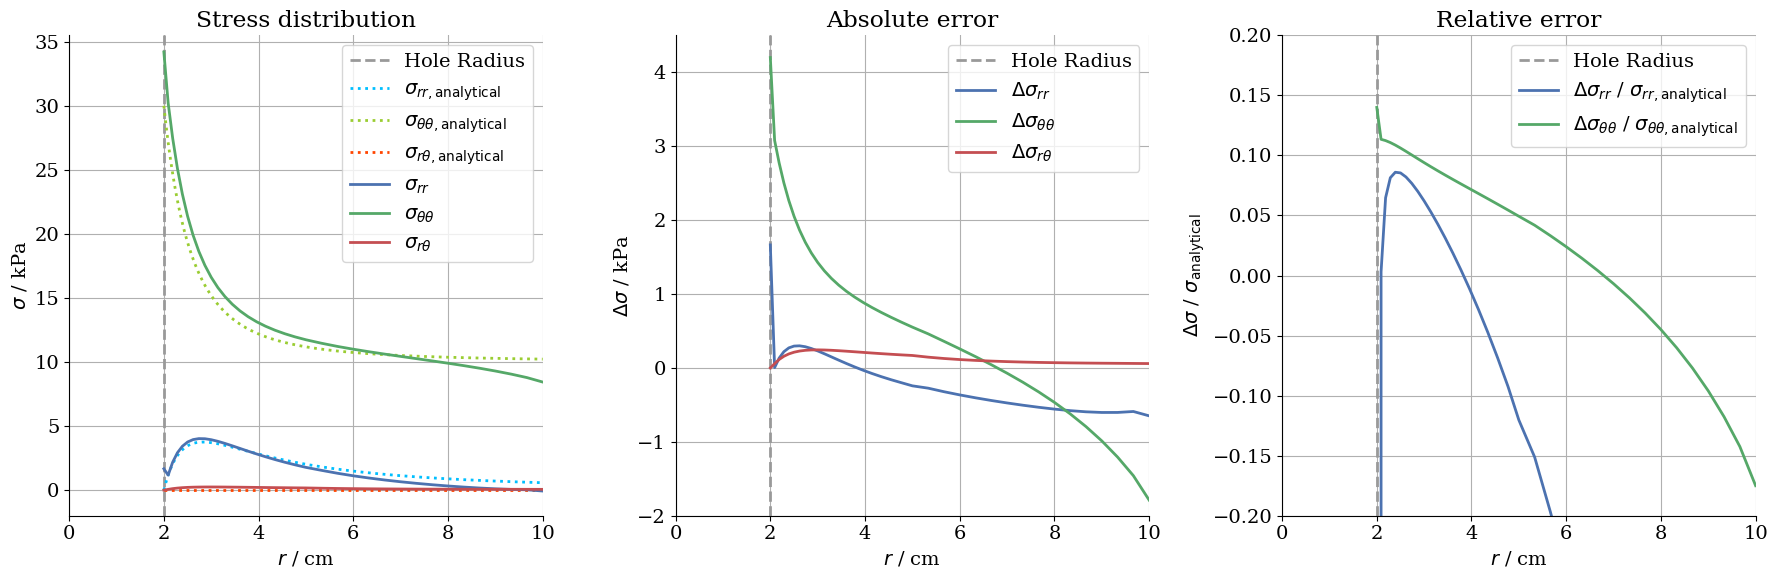

In [22]:
r = np.linspace(2, 10, 1000)

fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
for i in range(3):
    ax[i].axvline(2, color="0.6", linestyle="--", label="Hole Radius")
    ax[i].grid(True)
    ax[i].set(xlim=(0, 10))
    ax[i].set_xlabel("$r$ / cm")

ax[0].plot(
    r,
    kirsch_sig_rr(10, r, -90, 2),
    color="deepskyblue",
    linestyle=":",
    label=r"$\sigma_{rr,\mathrm{analytical}}$",
)
ax[0].plot(
    r,
    kirsch_sig_tt(10, r, -90, 2),
    color="yellowgreen",
    linestyle=":",
    label=r"$\sigma_{\theta\theta,\mathrm{analytical}}$",
)
ax[0].plot(
    r,
    kirsch_sig_rt(10, r, -90, 2),
    color="orangered",
    linestyle=":",
    label=r"$\sigma_{r\theta,\mathrm{analytical}}$",
)

ax[0].plot(dist_sorted, sig_rr_sorted * 1000, label=r"$\sigma_{rr}$")
ax[0].plot(dist_sorted, sig_tt_sorted * 1000, label=r"$\sigma_{\theta\theta}$")
ax[0].plot(dist_sorted, sig_rt_sorted * 1000, label=r"$\sigma_{r\theta}$")

ax[0].set_ylabel(r"$\sigma$ / kPa")
ax[0].set(ylim=(-2, 35.5))
ax[0].legend(loc="upper right")

ax[1].plot(dist_sorted, f_abs_rr, label=r"$\Delta\sigma_{rr}$")
ax[1].plot(dist_sorted, f_abs_tt, label=r"$\Delta\sigma_{\theta\theta}$")
ax[1].plot(dist_sorted, f_abs_rt, label=r"$\Delta\sigma_{r\theta}$")

# ax[1].spines['bottom'].set_position('zero')
ax[1].spines["top"].set_color("none")
ax[1].xaxis.tick_bottom()
ax[1].set_ylabel(r"$\Delta\sigma$ / kPa")
ax[1].set(ylim=(-2, 4.5))
ax[1].legend(loc="upper right")

ax[2].plot(
    dist_sorted,
    f_rel_rr,
    label=r"$\Delta\sigma_{rr}$ / $\sigma_{rr,\mathrm{analytical}}$",
)
ax[2].plot(
    dist_sorted,
    f_rel_tt,
    label=r"$\Delta\sigma_{\theta\theta}$ / $\sigma_{\theta\theta,\mathrm{analytical}}$",
)
# ax[2].plot(dist_sorted, f_rel_rt, label = r"$\Delta\sigma_{r\theta}$ / $\sigma_{r\theta,analytical}$")
ax[2].set_ylim(-0.2, 0.2)

ax[2].set_ylabel(r"$\Delta\sigma$ / $\sigma_{\mathrm{analytical}}$")
ax[2].legend()  # loc="upper right")

ax[0].set_title("Stress distribution")
ax[1].set_title("Absolute error")
ax[2].set_title("Relative error")

fig.tight_layout()

### Stress distribution along the diagonal ($\theta = 45°$)

In [23]:
pt1 = (0, 0, 0)
pt2 = (10, 10, 0)
diagonal = pv.Line(
    pt1, pt2, resolution=2
)  # erstellt Linie zwischen den Punkten und teilt sie in 2 Teile (resolution)
line_mesh = mesh.slice_along_line(
    diagonal
)  # Schnitt durch das Gitter entlang der Linie (ergibt 1D Gitter mit 35 Zellen und 36 Punkten)

xs = line_mesh.points[:, 0]  # x (0) coordinate of each point (Spalte 0)
ys = line_mesh.points[:, 1]  # y Koordinate jedes Punktes (Spalte 1)
dist_from_origin = np.hypot(xs, ys)  # Abstand vom Ursprung (Radius)
indices_sorted = np.argsort(
    dist_from_origin
)  # Indizes der Punkte sortieren nach ihrem Abstand vom Ursprung
dist_sorted = dist_from_origin[indices_sorted]  # index magic

In [24]:
sig = line_mesh.point_data[
    "sigma"
]  # Spannung in Kelvin Darstellung als 4 zeiliger Vector statt 3x3 Matrix
# Achtung (CL): Das ist nicht ganz die Kelvin-Darstellung. Die Kelvin-Darstellung hat noch Faktoren sqrt(2) bei den Nichtdiagonalelementen.

In [25]:
num_points = sig.shape[0]  # entspricht len(sig) d.h Anzahl der Punkte, hier 36
sig_rr = np.zeros(num_points)  # Liste von 36 Nullen
sig_tt = np.zeros(num_points)
sig_rt = np.zeros(num_points)
f_abs_rr = np.zeros(num_points)
f_abs_tt = np.zeros(num_points)
f_abs_rt = np.zeros(num_points)
f_rel_rr = np.zeros(num_points)
f_rel_tt = np.zeros(num_points)
f_rel_rt = np.zeros(num_points)

In [26]:
for pt_idx in range(num_points):
    sig_vec = sig[pt_idx, :]
    xs = line_mesh.points[pt_idx, 0]
    ys = line_mesh.points[pt_idx, 1]
    sig_polar = vec4_to_mat3x3polar(sig_vec, xs, ys)
    sig_rr[pt_idx] = sig_polar[0, 0]
    sig_tt[pt_idx] = sig_polar[1, 1]
    sig_rt[pt_idx] = sig_polar[0, 1]

In [27]:
sig_rr_sorted = sig_rr[indices_sorted]
sig_tt_sorted = sig_tt[indices_sorted]
sig_rt_sorted = sig_rt[indices_sorted]

In [28]:
for pt_idx in range(num_points):
    f_abs_rr[pt_idx] = sig_rr_sorted[pt_idx] * 1000 - kirsch_sig_rr(
        10, dist_sorted[pt_idx], -45, 2
    )
    f_abs_tt[pt_idx] = sig_tt_sorted[pt_idx] * 1000 - kirsch_sig_tt(
        10, dist_sorted[pt_idx], -45, 2
    )
    f_abs_rt[pt_idx] = sig_rt_sorted[pt_idx] * 1000 - kirsch_sig_rt(
        10, dist_sorted[pt_idx], -45, 2
    )
    if kirsch_sig_rr(10, dist_sorted[pt_idx], -45, 2) == 0:
        f_rel_rr[pt_idx] = f_abs_rr[pt_idx] / 1e-2
    else:
        f_rel_rr[pt_idx] = f_abs_rr[pt_idx] / kirsch_sig_rr(
            10, dist_sorted[pt_idx], -45, 2
        )
    if kirsch_sig_tt(10, dist_sorted[pt_idx], -45, 2) == 0:
        f_rel_tt[pt_idx] = f_abs_tt[pt_idx] / 1e-2
    else:
        f_rel_tt[pt_idx] = f_abs_tt[pt_idx] / kirsch_sig_tt(
            10, dist_sorted[pt_idx], -45, 2
        )
    if kirsch_sig_rt(10, dist_sorted[pt_idx], -45, 2) == 0:
        f_rel_rt[pt_idx] = f_abs_rt[pt_idx] / 1e-2
    else:
        f_rel_rt[pt_idx] = f_abs_rt[pt_idx] / kirsch_sig_rt(
            10, dist_sorted[pt_idx], -45, 2
        )

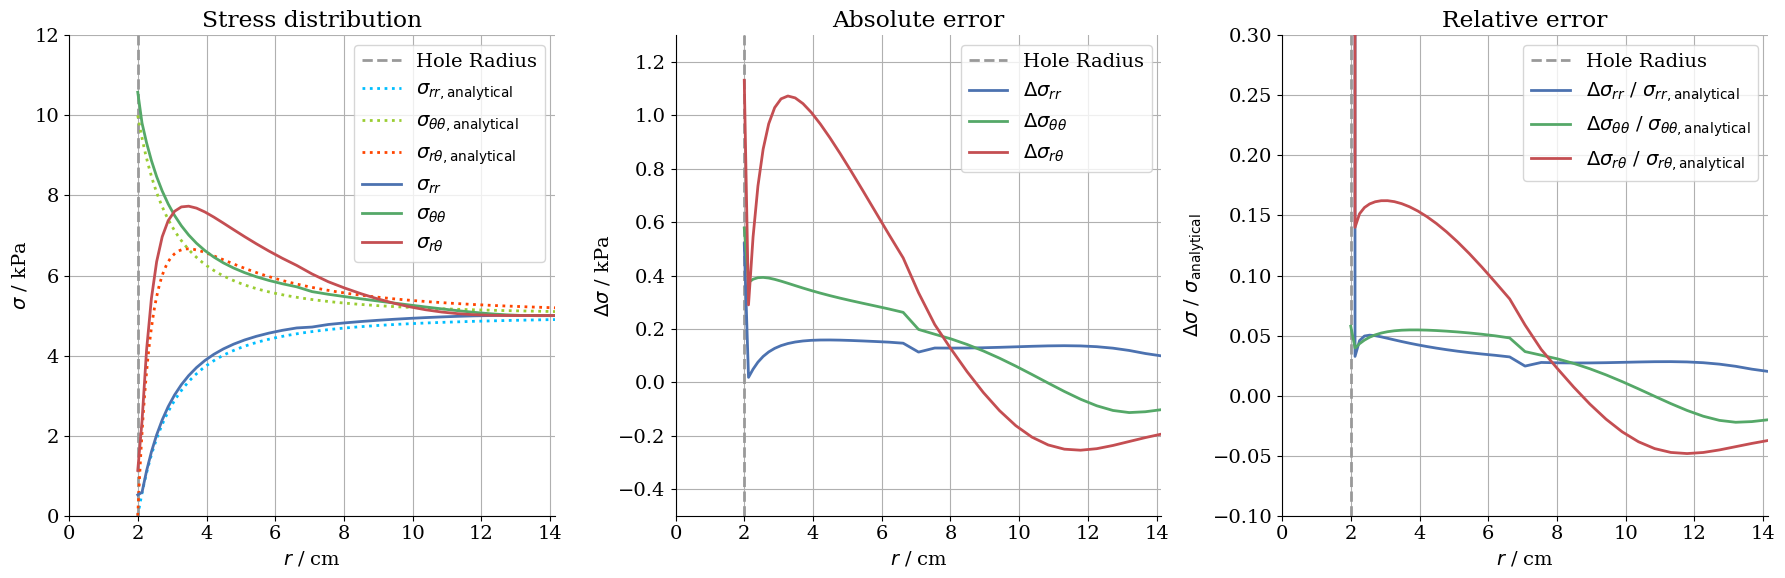

In [29]:
r = np.linspace(2, 14.14, 1000)

fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

for i in range(3):
    ax[i].axvline(2, color="0.6", linestyle="--", label="Hole Radius")
    ax[i].grid(True)
    ax[i].set(xlim=(0, 14.14))
    ax[i].set_xlabel("$r$ / cm")

ax[0].plot(
    r,
    kirsch_sig_rr(10, r, -45, 2),
    color="deepskyblue",
    linestyle=":",
    label=r"$\sigma_{rr,\mathrm{analytical}}$",
)
ax[0].plot(
    r,
    kirsch_sig_tt(10, r, -45, 2),
    color="yellowgreen",
    linestyle=":",
    label=r"$\sigma_{\theta\theta,\mathrm{analytical}}$",
)
ax[0].plot(
    r,
    kirsch_sig_rt(10, r, -45, 2),
    color="orangered",
    linestyle=":",
    label=r"$\sigma_{r\theta,\mathrm{analytical}}$",
)

ax[0].plot(dist_sorted, sig_rr_sorted * 1000, label=r"$\sigma_{rr}$")
ax[0].plot(dist_sorted, sig_tt_sorted * 1000, label=r"$\sigma_{\theta\theta}$")
ax[0].plot(dist_sorted, sig_rt_sorted * 1000, label=r"$\sigma_{r\theta}$")

ax[0].legend(loc="upper right")
ax[0].set_ylabel(r"$\sigma$ / kPa")
ax[0].set(ylim=(0, 12))

ax[1].plot(dist_sorted, f_abs_rr, label=r"$\Delta\sigma_{rr}$")
ax[1].plot(dist_sorted, f_abs_tt, label=r"$\Delta\sigma_{\theta\theta}$")
ax[1].plot(dist_sorted, f_abs_rt, label=r"$\Delta\sigma_{r\theta}$")

ax[1].spines["top"].set_color("none")
ax[1].xaxis.tick_bottom()
ax[1].set_ylabel(r"$\Delta\sigma$ / kPa")
ax[1].set(ylim=(-0.5, 1.3))
ax[1].legend(loc="upper right")

ax[2].plot(
    dist_sorted,
    f_rel_rr,
    label=r"$\Delta\sigma_{rr}$ / $\sigma_{rr,\mathrm{analytical}}$",
)
ax[2].plot(
    dist_sorted,
    f_rel_tt,
    label=r"$\Delta\sigma_{\theta\theta}$ / $\sigma_{\theta\theta,\mathrm{analytical}}$",
)
ax[2].plot(
    dist_sorted,
    f_rel_rt,
    label=r"$\Delta\sigma_{r\theta}$ / $\sigma_{r\theta,\mathrm{analytical}}$",
)
ax[2].set(ylim=(-0.1, 0.3))

ax[2].set_ylabel(r"$\Delta\sigma$ / $\sigma_{\mathrm{analytical}}$")
ax[2].legend(loc="upper right")

ax[0].set_title("Stress distribution")
ax[1].set_title("Absolute error")
ax[2].set_title("Relative error")

fig.tight_layout()

### Stress distribution along the $y$-axis ($\theta=0°$)

In [30]:
pt1 = (0, 0, 0)
pt2 = (0, 10, 0)
yaxis = pv.Line(pt1, pt2, resolution=2)
line_mesh = mesh.slice_along_line(yaxis)

xs = line_mesh.points[:, 0]
ys = line_mesh.points[:, 1]
dist_from_origin = np.hypot(xs, ys)
indices_sorted = np.argsort(dist_from_origin)
dist_sorted = dist_from_origin[indices_sorted]

In [31]:
sig = line_mesh.point_data["sigma"]

In [32]:
num_points = sig.shape[0]
sig_rr = np.zeros(num_points)
sig_tt = np.zeros(num_points)
sig_rt = np.zeros(num_points)
f_abs_rr = np.zeros(num_points)
f_abs_tt = np.zeros(num_points)
f_abs_rt = np.zeros(num_points)
f_rel_rr = np.zeros(num_points)
f_rel_tt = np.zeros(num_points)
f_rel_rt = np.zeros(num_points)

In [33]:
for pt_idx in range(num_points):
    sig_vec = sig[pt_idx, :]
    xs = line_mesh.points[pt_idx, 0]
    ys = line_mesh.points[pt_idx, 1]
    sig_polar = vec4_to_mat3x3polar(sig_vec, xs, ys)
    sig_rr[pt_idx] = sig_polar[0, 0]
    sig_tt[pt_idx] = sig_polar[1, 1]
    sig_rt[pt_idx] = sig_polar[0, 1]

In [34]:
sig_rr_sorted = sig_rr[indices_sorted]
sig_tt_sorted = sig_tt[indices_sorted]
sig_rt_sorted = sig_rt[indices_sorted]

In [35]:
for pt_idx in range(num_points):
    f_abs_rr[pt_idx] = sig_rr_sorted[pt_idx] * 1000 - kirsch_sig_rr(
        10, dist_sorted[pt_idx], 0, 2
    )
    f_abs_tt[pt_idx] = sig_tt_sorted[pt_idx] * 1000 - kirsch_sig_tt(
        10, dist_sorted[pt_idx], 0, 2
    )
    f_abs_rt[pt_idx] = sig_rt_sorted[pt_idx] * 1000 - kirsch_sig_rt(
        10, dist_sorted[pt_idx], 0, 2
    )
    if kirsch_sig_rr(10, dist_sorted[pt_idx], 0, 2) == 0:
        f_rel_rr[pt_idx] = f_abs_rr[pt_idx] / 1e-6
    else:
        f_rel_rr[pt_idx] = f_abs_rr[pt_idx] / kirsch_sig_rr(
            10, dist_sorted[pt_idx], 0, 2
        )
    if kirsch_sig_tt(10, dist_sorted[pt_idx], 0, 2) == 0:
        f_rel_tt[pt_idx] = f_abs_tt[pt_idx] / 1e-6
    else:
        f_rel_tt[pt_idx] = f_abs_tt[pt_idx] / kirsch_sig_tt(
            10, dist_sorted[pt_idx], 0, 2
        )
    if kirsch_sig_rt(10, dist_sorted[pt_idx], 0, 2) == 0:
        f_rel_rt[pt_idx] = f_abs_rt[pt_idx] / 1e-6
    else:
        f_rel_rt[pt_idx] = f_abs_rt[pt_idx] / kirsch_sig_rt(
            10, dist_sorted[pt_idx], 0, 2
        )

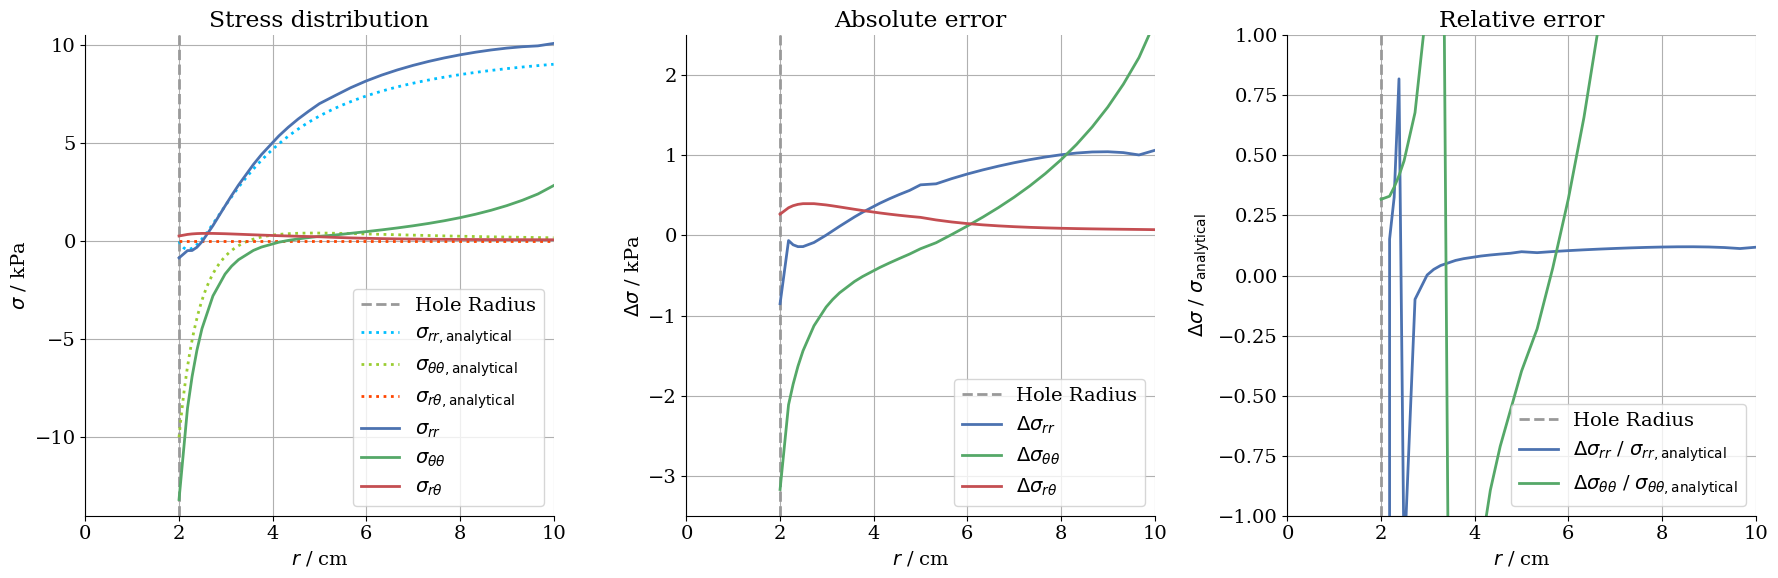

In [36]:
r = np.linspace(2, 10, 1000)

fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
for i in range(3):
    ax[i].axvline(2, color="0.6", linestyle="--", label="Hole Radius")
    ax[i].grid(True)
    ax[i].set(xlim=(0, 10))
    ax[i].set_xlabel("$r$ / cm")

ax[0].plot(
    r,
    kirsch_sig_rr(10, r, 0, 2),
    color="deepskyblue",
    linestyle=":",
    label=r"$\sigma_{rr,\mathrm{analytical}}$",
)
ax[0].plot(
    r,
    kirsch_sig_tt(10, r, 0, 2),
    color="yellowgreen",
    linestyle=":",
    label=r"$\sigma_{\theta\theta,\mathrm{analytical}}$",
)
ax[0].plot(
    r,
    kirsch_sig_rt(10, r, 0, 2),
    color="orangered",
    linestyle=":",
    label=r"$\sigma_{r\theta,\mathrm{analytical}}$",
)

ax[0].plot(dist_sorted, sig_rr_sorted * 1000, label=r"$\sigma_{rr}$")
ax[0].plot(dist_sorted, sig_tt_sorted * 1000, label=r"$\sigma_{\theta\theta}$")
ax[0].plot(dist_sorted, sig_rt_sorted * 1000, label=r"$\sigma_{r\theta}$")

ax[0].set_ylabel(r"$\sigma$ / kPa")
ax[0].set(ylim=(-14, 10.5))
ax[0].legend(loc="lower right")
ax[0].spines["right"].set_color("none")
ax[0].spines["top"].set_color("none")
ax[0].xaxis.set_ticks_position("bottom")
ax[0].yaxis.set_ticks_position("left")
ax[0].spines["left"].set_position(("data", 0))

ax[1].plot(dist_sorted, f_abs_rr, label=r"$\Delta\sigma_{rr}$")
ax[1].plot(dist_sorted, f_abs_tt, label=r"$\Delta\sigma_{\theta\theta}$")
ax[1].plot(dist_sorted, f_abs_rt, label=r"$\Delta\sigma_{r\theta}$")

ax[1].spines["top"].set_color("none")
ax[1].xaxis.tick_bottom()
ax[1].set_ylabel(r"$\Delta\sigma$ / kPa")
ax[1].set(ylim=(-3.5, 2.5))
ax[1].legend(loc="lower right")

ax[2].plot(
    dist_sorted,
    f_rel_rr,
    label=r"$\Delta\sigma_{rr}$ / $\sigma_{rr,\mathrm{analytical}}$",
)
ax[2].plot(
    dist_sorted,
    f_rel_tt,
    label=r"$\Delta\sigma_{\theta\theta}$ / $\sigma_{\theta\theta,\mathrm{analytical}}$",
)
# ax[2].plot(dist_sorted, f_rel_rt, label = r"$\Delta\sigma_{r\theta}$ / $\sigma_{r\theta,analytical}$")
ax[2].set(ylim=(-1, 1))
ax[2].set_ylabel(r"$\Delta\sigma$ / $\sigma_{\mathrm{analytical}}$")
ax[2].legend(loc="lower right")

ax[0].set_title("Stress distribution")
ax[1].set_title("Absolute error")
ax[2].set_title("Relative error")

fig.tight_layout()

### Error analysis

In this following section, the differences of the numerical to the analytical solution are discussed. Doing this, one studies various aspects of the numerical solution.

Whenever a problem is solved by finite element method (FEM), discretization errors occur. They arise from the creation of the mesh, since the result is calculated only at a finite number of nodes. Discretization errors can be minimized by refining the mesh. However, this increases computing time, so a compromise must be found.<br>
Accordingly, this error smaller or larger and has to be acceptable for the field of application.

The following image illustrates the chosen mesh for this benchmark example. In the area around the cavity, the stress gradients are rather high, as can also be seen in the diagrams above, and thus call for a finer mesh resolution.

2025-10-30 14:43:30.717 (   3.736s) [    7F2C149D8400]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=
/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/.venv/lib/python3.13/site-packages/pyvista/plotting/renderer.py:1846: PyVistaDeprecationWarning: `xlabel` is deprecated. Use `xtitle` instead.
  warnings.warn(
/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/.venv/lib/python3.13/site-packages/pyvista/plotting/renderer.py:1852: PyVistaDeprecationWarning: `ylabel` is deprecated. Use `ytitle` instead.
  warnings.warn(


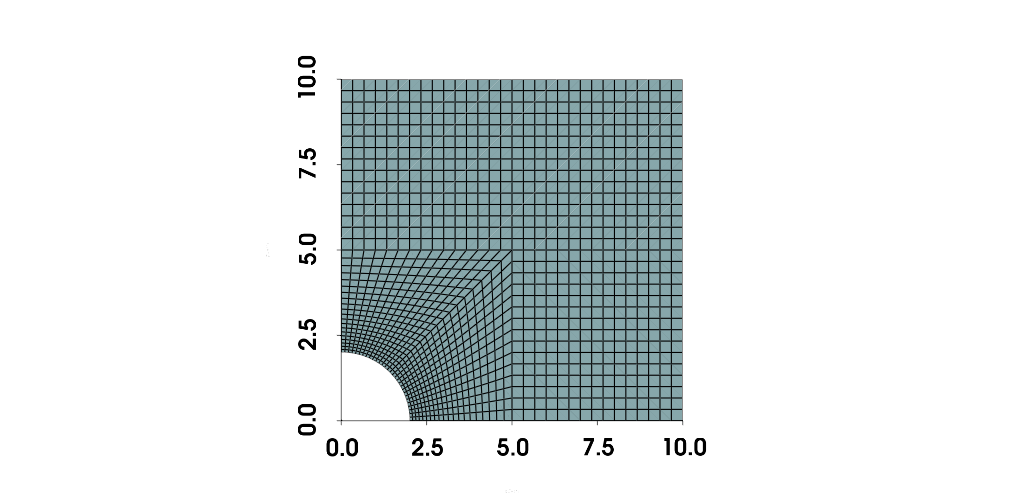

In [37]:
plotter = pv.Plotter(window_size=[1024, 500])

plotter.add_mesh(mesh, show_edges=True, show_scalar_bar=False, color=None, scalars=None)
plotter.show_bounds(ticks="outside", xlabel="x / cm", ylabel="y / cm")
# plotter.add_axes()
plotter.view_xy()
plotter.show()

All three stress components of the numerical solution show a more or less pronounced buckle most obviously along the diagonal- and y-axes in the middle of the observed radius range. The reason for this is the fact that the **mesh is refined** in the area around the hole. This increases the accuracy and resolution, but at the same time, the cells become distorted rectangles instead of squares.

Another source of error is the **limitation of the plate's geometry**. In a continuous, infinitely extended plate the stress distribution approaches the primary stress state with distance from the cavity. The example of the stress distribution along the y-axis shows that the numerical solution for $\sigma_{rr}$ reaches the Neumann boundary condition set with a value of $10\, \text{kPa}$ for $\text{r} = 10\, \text{cm}$. With Kirsch's Solution for the analytical calculation, $\sigma_{rr}$ converges only at infinity towards the value of $10\, \text{kPa}$ and amounts approximately $9\, \text{kPa}$ for $r = 10\, \text{cm}$.<br>
A similar error becomes visible along the $x$-axis. The Neumann boundary condition constrains the normal stress along the right edge to be zero . As a consequence $\sigma_{rr}$ must reach a value of $0\, \text{MPa}$ for $r = 10\, \text{cm}$ to satisfy the boundary condition. In the analytical solution however, $\sigma_{rr}$ approaches zero at infinity and thus is larger than in the numerical solution. Errors of that type can be minimized by increasing the plates dimensions or decreasing the diameter of the cavity, so that the boundary conditions do not interfere with the cavity-disturbed stress distribution.<br>
As a rule of thumb, it can be assumed in this case that the boundaries of the problem can be drawn after at least five-hole radii.

Further artefacts, called **extrapolation errors** occur at all boundaries of the numerical model. It can be recognised by a discontinuity in the graph for the stress distribution and absolute error next to the cavity ($r = 2\, \text{cm}$) and the plate boundaries ($r = 10\, \text{cm}$ resp. $r = 14.14\, \text{cm}$). The stress is derived from strain and this in turn from the nodal displacement. Therefore, there are no calculated stress magnitudes on the nodes, but they are formed as the average value of the neighboring cells. However, if the node is located on the edge directly next to the cavity or plate boundary, no average value can be formed, but the stress is extrapolated. In contrast to most of the other errors, this one is not based on an defect in the calculation of the numerical model, but rather in the output.

### 2D Color Plots

As can see below the 2D color plots of the numerical solution resemble those of the analytical solution. The plot of the tangential stress $\sigma_{\theta\theta}$ also shows a threefold stress concentration. From the plot of the radial stress $\sigma_{rr}$ it becomes clear that the Neumann boundary condition that respects the applied tensile stress of $10 \text{kPa}$  at the top boundary is satisfied.

In [38]:
points = mesh.point_data["sigma"].shape[0]

In [39]:
sig_polar = np.zeros([points, 3, 3])
sig_rr = np.zeros([points, 1])
sig_tt = np.zeros([points, 1])
sig_rt = np.zeros([points, 1])

In [40]:
xs = mesh.points[:, 0]
ys = mesh.points[:, 1]
sig_vec = mesh.point_data["sigma"]
for i in range(xs.shape[0]):
    sig_polar[i] = vec4_to_mat3x3polar(sig_vec[i, :], xs[i], ys[i])
    sig_rr[i] = sig_polar[i, 0, 0]
    sig_tt[i] = sig_polar[i, 1, 1]
    sig_rt[i] = sig_polar[i, 0, 1]

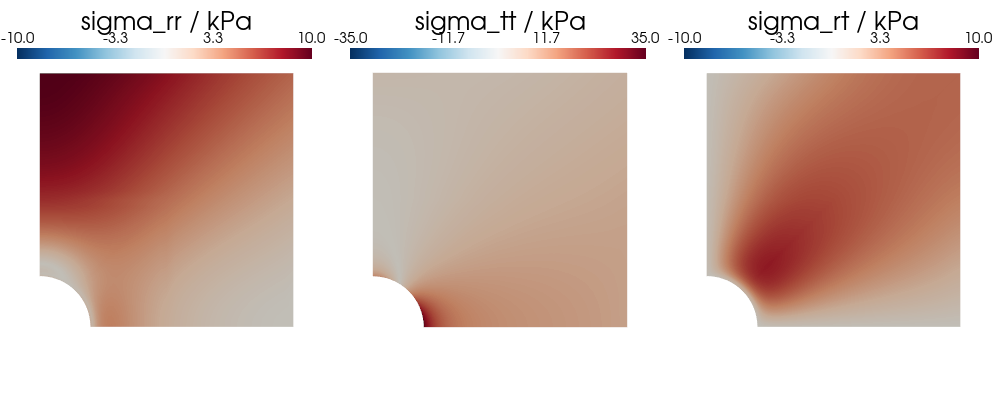

In [41]:
mesh2 = mesh.copy(deep=False)  # workaround some pyvista bug with multiple plots
mesh3 = mesh.copy(deep=False)

sargs = {
    "title": "sigma_rr / kPa",
    "title_font_size": 25,
    "label_font_size": 15,
    "n_labels": 4,
    "position_x": 0.05,
    "position_y": 0.85,
    "fmt": "%.1f",
    "width": 0.9,
}
clim = [-10, 10]

p = pv.Plotter(shape=(1, 3), border=False)
p.subplot(0, 0)
p.add_mesh(
    mesh,
    scalars=sig_rr * 1000,
    show_edges=False,
    show_scalar_bar=True,
    colormap="RdBu_r",
    clim=clim,
    scalar_bar_args=sargs,
)
# p.show_bounds(ticks="outside", xlabel="", ylabel="")
# p.add_axes()
p.view_xy()
p.camera.zoom(2)

sargs1 = {
    "title": "sigma_tt / kPa",
    "title_font_size": 25,
    "label_font_size": 15,
    "n_labels": 4,
    "position_x": 0.05,
    "position_y": 0.85,
    "fmt": "%.1f",
    "width": 0.9,
}
clim = [-35, 35]

p.subplot(0, 1)
p.add_mesh(
    mesh2,
    scalars=sig_tt * 1000,
    show_edges=False,
    show_scalar_bar=True,
    colormap="RdBu_r",
    clim=clim,
    scalar_bar_args=sargs1,
)
# p.show_bounds(ticks="outside", xlabel="", ylabel="")
# p.add_axes()
p.view_xy()
p.camera.zoom(2)

sargs2 = {
    "title": "sigma_rt / kPa",
    "title_font_size": 25,
    "label_font_size": 15,
    "n_labels": 4,
    "position_x": 0.05,
    "position_y": 0.85,
    "fmt": "%.1f",
    "width": 0.9,
}
clim = [-10, 10]

p.subplot(0, 2)
p.add_mesh(
    mesh3,
    scalars=sig_rt * 1000,
    show_edges=False,
    show_scalar_bar=True,
    colormap="RdBu_r",
    clim=clim,
    scalar_bar_args=sargs2,
)
# p.show_bounds(ticks="outside", xlabel="", ylabel="")
# p.add_axes()
p.view_xy()
p.camera.zoom(2)

p.window_size = [1000, 400]
p.show()

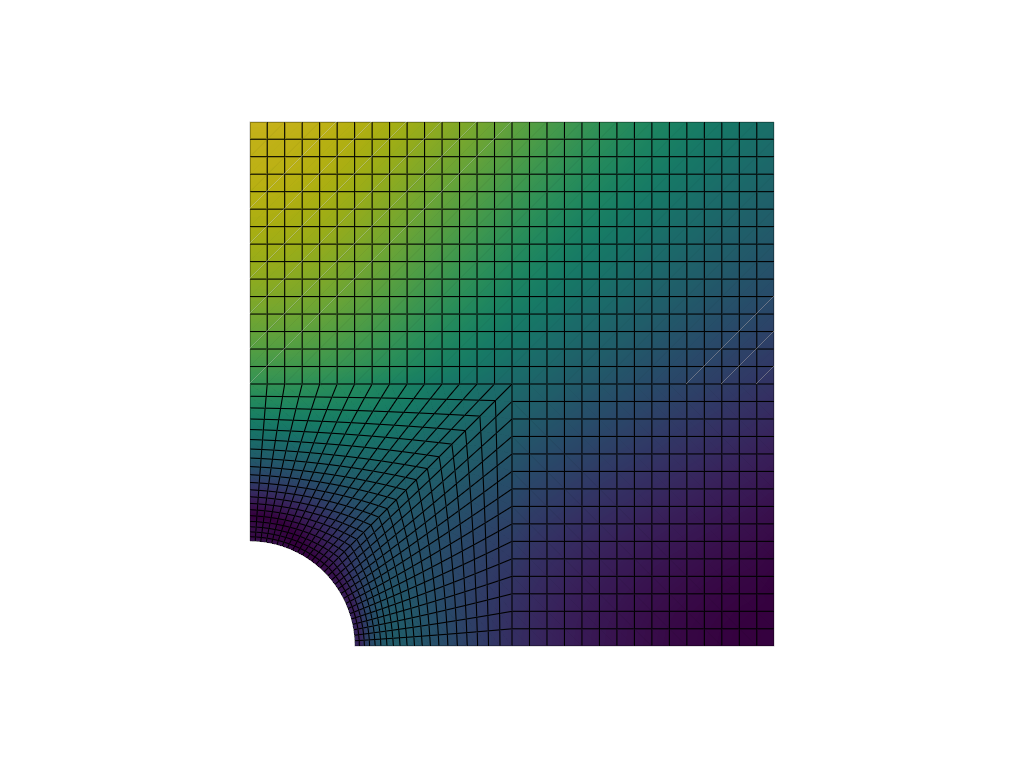

In [42]:
if True:
    plotter = pv.Plotter()

    sargs = {
        "title": "sigma_rr",
        "title_font_size": 20,
        "label_font_size": 16,
        "n_labels": 4,
        "position_x": 0.2,
        "position_y": 0.9,
        "fmt": "%.1f",
    }

    plotter.add_mesh(
        mesh,
        scalars=sig_rr * 1000,
        show_edges=True,
        show_scalar_bar=False,
        scalar_bar_args=sargs,
    )
    # plotter.show_bounds(ticks="outside")
    # plotter.add_axes()
    plotter.view_xy()
    plotter.show()

In [43]:
if False:
    plotter = pv.Plotter()

    sargs = {
        "title": "sigma_tt",
        "title_font_size": 20,
        "label_font_size": 16,
        "n_labels": 4,
        "position_x": 0.2,
        "position_y": 0.9,
        "fmt": "%.1f",
    }

    plotter.add_mesh(
        mesh,
        scalars=sig_tt * 1000,
        show_edges=True,
        show_scalar_bar=False,
        scalar_bar_args=sargs,
    )
    # plotter.show_bounds(ticks="outside")
    # plotter.add_axes()
    plotter.view_xy()
    plotter.show()

In [44]:
if False:
    plotter = pv.Plotter()

    sargs = {
        "title": "sigma_rt",
        "title_font_size": 20,
        "label_font_size": 16,
        "n_labels": 4,
        "position_x": 0.2,
        "position_y": 0.9,
        "fmt": "%.1f",
    }

    plotter.add_mesh(
        mesh,
        scalars=sig_rt * 1000,
        show_edges=True,
        show_scalar_bar=True,
        scalar_bar_args=sargs,
    )
    plotter.show_bounds(ticks="outside")
    plotter.add_axes()
    plotter.view_xy()
    plotter.show()